# Convolutionalization

First technique we see for semantic segmentation. It was mosre used in the past.

## CONVOLUTIONALIZATION : IDEA

**Starting point: classifier NN**

Let's suppose that we have an already trained classifier NN. It takes in input an image and it classifies it, by returning the predicted categorical distribution. The output is a categorical distribution over the classes.

This classifies NN is a Conv NN. So, we know that the structure is the following:
- Conv part: features extraction
- Dense part: features exploitation

Example of classifier NN on the MNIST dataset: NN which takes in input an image representing a digit, and it returns the probability distribution over the classes/digits.

**Aim: segmenter NN**

Our aim is to build a segmenter NN. It takes in input an image and it returns an image, where for each pixel we have a categorical distribution over the classes. The output image has $k$ channels, one for each possible class.

Example of segmenter NN on the MNIST dataset: NN which takes in input an image containing more digits, and it returns an image containing, for each pixel, the probability distribution over the classes/digits.

**Convolutionalization**

We can build our segmenter NN by using the classifier NN. 

The idea is that we slide our classifier NN over each pixel of the input image. In this way, for each pixel, we get a categorical distribution. We obtain a categorical distribution for each pixel. Image with $k$ channels.

We slide the classifier NN over each position. We convolve the classifier NN across the input image. Like a kernel. This is calles *convolutionalization*.

We build our segmenter NN in this way.

**Convolutionalization in practice**

So, we want to convolve our classifier NN over the input image. 

For doing so, we transform our classifier NN into a fully Conv NN. **Fully CNN**. Basically, same NN, but it is fully Convolutional. Only Conv layers.

More precisely, same NN of the Conv NN, but we take the Dense part, and we transform it to a Con part. We transform Dense layers to Conv layers.

By transformin our classifier NN into its fully Conv version, we are applying convolutionalization. This fully CNN represents a single big convolution, which is exactly about convolving our classifier NN over the input image.

And this new NN is our segmenter NN.

### Sum up

- We have our already trained **classifier NN**.
    * It's not a fully CNN (it has also dense layer)
    * It returns a single output. Single categorical distribution.
- We make transform this classifier into a fully CNN: this is our **segmenter NN**.
    * Fully CNN. Only Conv layers (no dense layers).
    * It returns a structured output. It returns an image, in which for each pixel we have the corresponding categorical distribution. Image with $k$ channels, one for each class.
    * This segmenter NN can be seen as a single convolution, consisting in convolving the classifier NN over the input image.
    
This transformation is called **convolutionalization**.

### We don't need any additional training

A very interesting point is that, once we have our trained classifier NN, we don't need any additional training. We don't need to do a specific train for our segmenter NN. We take the exact same weigths of the classifier NN.

Advantages of this:
- Only one training phase;
- We don't need a segmented dataset (Which can be difficult to get).

### Problem: background category

A classic classifier NN does not need to worry about the background cateogry. However, if we want to use it for building a segmenter NN, we have to worry about the background category. Let's better explain this with an example.

MNIST dataset. If we simply build a classifier NN, we consider only $10$ classes. corresponding to the $10$ digits. We want to classify the $10$ digits.

However, the segmenter NN instead has $11$ classes. Because we have to consider also the background. We have to classify each pixel of the image, and some pixels can be simply be background pixels. Therefore, we need to be able to classify also the background: $11$ classes.

This means that the starting classifier NN needs to be able as well to classify also the background. $11$ classes.

How to train our classifier in recognizing the background if in our MNIST dataset we have only images about digits? We have to syntethize background images... See later. 

## CONVOLUTIONALIZATION ON THE MNIST DATASET

Let's apply Convolutionalization on the MNIST dataset.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

### Dataset

In [1]:
from tensorflow.keras.datasets import mnist

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [6]:
# Normalization
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# Adding the channels dimensions into the train set
(n_train, w, h) = x_train.shape
x_train = x_train.reshape(n_train, w, h, 1)

# Adding the channels dimensions into the test set
(n_test, w, h) = x_test.shape
x_test = x_test.reshape(n_test, w, h, 1)

### Setting

We have our classic MNIS dataset. Each image represnts a single digit.

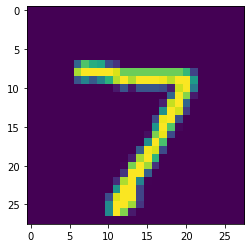

In [7]:
plt.imshow(x_test[0])

Now, we suppose that we want to address the segmentation task. We have an image with several digits, and we want to classify each pixel.

Let's build an example of such image.

In [10]:
img = np.zeros((128,128,1))
img[12:40,6:34] = x_test[15]
img[40:68,30:58] = x_test[14]
img[15:43,45:73] = x_test[13]
img[5:33,75:103] = x_test[12]
img[45:73,90:118] = x_test[11]
img[89:117,70:98] = x_test[9]
img[80:108,25:53] = x_test[6]

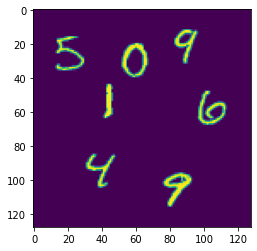

In [11]:
imageplot = plt.imshow(np.reshape(img,(128,128)))
plt.show()

It is important to notice that this image has bigger spatial dimensions: $128x128$.

In [32]:
img.shape

(128, 128, 1)

For solving this segmentation task, we use Convolutionalization. 
- First we train a classic classifier NN.
- Then we transform it into a segmenter NN.

## CLASSIFER NN

So, let's train our classifier NN. We use a Conv NN. So, two parts: Conv part (features extraction); Dense part (features exploitation).

### Background category

We must be careful that this classifier NN is not a completely classic classifier. It must be able to recognize also the background category. So, it has $11$ classes.

Given a MNISt image, it returns a categorical distribution over $11$ classes: the $10$ classes and the background class.

Problem: in our MNIST dataset, we don't have examples of background images. How can we train our classifier NN over the $11$ classes if we don't have any background examples?

Solution: we syntetize from scratch background images. Indeed, this is quite an easy task: almost completely black images.

Let's syntetize background train images ($6000$) and background test images ($1000$). We randomly generated pixel values between $0$ and $5$ (normalizing, we get between $0$ and $5/255$).

In [12]:
background_train = np.random.randint(0,5,(6000,28,28,1))/255.
background_test = np.random.randint(0,5,(1000,28,28,1))/255.

Let's visualize a background image.

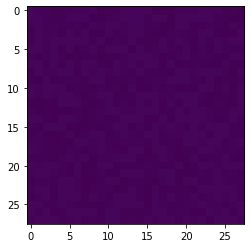

In [18]:
from matplotlib.colors import Normalize

plt.imshow(background_train[0], norm=Normalize(vmin=0,vmax=1))

Finally, we add these images into our dataset.

In [20]:
x_train_bg = np.concatenate((x_train,background_train))
x_test_bg = np.concatenate((x_test,background_test))

We have to add also the corresponding labels. **We use $10$ as label for the background class**.

In [21]:
y_train_bg = np.concatenate((y_train,np.ones(6000)*10))
y_test_bg = np.concatenate((y_test,np.ones(1000)*10))

### Defining the classifier NN

Classic Conv NN for classifing images. We define a small NN.
- Conv part. Three Conv layers. We decrease the spatial dimensions, and, at the same time, we increase the number of channels.
- Flattening into a single dimension. We do so by using a Global Max Pooling layer.
- Dense part. Two Dense layers. The output layer has $11$ outputs (one for each class), and softmax activation function.

For all the layers except the last one, we use the *swish* activation function.

In [24]:
from tensorflow.keras.layers import Input, Conv2D, GlobalMaxPool2D, Dense
from tensorflow.keras import Model

In [26]:
# Input
xin = Input(shape=(28,28,1))

# Conv part
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)

# FLattening
x = GlobalMaxPool2D()(x)

# Dense part
x = Dense(units=64, activation = 'swish')(x)
out = Dense(units=11, activation = 'softmax')(x) #we have now 11 categories

# Model
classifier = Model(inputs=[xin],outputs=[out], name='classifier')

In [27]:
classifier.summary()

Model: "classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 16)        160       
                                                                 
 conv2d_7 (Conv2D)           (None, 7, 7, 32)          4640      
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_max_pooling2d_2 (Glo  (None, 64)               0         
 balMaxPooling2D)                                                
                                                                 
 dense_4 (Dense)             (None, 64)                4160      
                                                        

### Compile the classifier NN

We use the sparse categorical crossentropy. So, we can directly pass the labels during training.

In [28]:
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

**Note: we should use sparse categorical crossentropy with from_logits=True, and don't specify any activation function in the last layer.**

### Train the classifier NN

In [30]:
classifier.fit(x_train_bg, y_train_bg, epochs=10, batch_size=100, validation_data=(x_test_bg, y_test_bg))

Epoch 1/10
660/660 [==============================] - 7s 10ms/step - loss: 0.4220 - accuracy: 0.8738 - val_loss: 0.1502 - val_accuracy: 0.9551
Epoch 2/10
660/660 [==============================] - 6s 10ms/step - loss: 0.1168 - accuracy: 0.9656 - val_loss: 0.0900 - val_accuracy: 0.9726
Epoch 3/10
660/660 [==============================] - 6s 10ms/step - loss: 0.0792 - accuracy: 0.9759 - val_loss: 0.0735 - val_accuracy: 0.9775
Epoch 4/10
660/660 [==============================] - 7s 10ms/step - loss: 0.0610 - accuracy: 0.9810 - val_loss: 0.0630 - val_accuracy: 0.9802
Epoch 5/10
660/660 [==============================] - 8s 12ms/step - loss: 0.0503 - accuracy: 0.9847 - val_loss: 0.0537 - val_accuracy: 0.9828
Epoch 6/10
660/660 [==============================] - 8s 13ms/step - loss: 0.0427 - accuracy: 0.9867 - val_loss: 0.0557 - val_accuracy: 0.9823
Epoch 7/10
660/660 [==============================] - 8s 12ms/step - loss: 0.0371 - accuracy: 0.9877 - val_loss: 0.0540 - val_accuracy: 0.9815

Good results!

**Save the weigths**

In [31]:
classifier.save_weights("classifier.hdf5")

## SEGMENTER NN

Let's now define our segmenter NN. We define it by applying convolutionalization on the classifier NN: we transform the classifier NN into a fully Conv NN.

### Defining the segmenter NN

The definition is trivial: exact same definition of the classifier NN. The only difference is that we remove the Global Max Pooling layer. We remove the flattening part.

In [35]:
# Input
xin = Input(shape=(28,28,1))

# Conv layers
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)

# ----- No flattening

# Dense layers
x = Dense(units=64, activation = 'swish')(x)
out = Dense(units=11, activation = 'softmax')(x) #we have now 11 categories

# Model
segmenter = Model(inputs=[xin],outputs=[out], name='segmenter')

What's the meaning of this? The Conv part is the same. But, then, we don't have the flattening anymore. And we are applying our Dense layers to a non-flat input. We are applying the Dense layers to images. 

Indeed, we can see from the summary that the Dense layers are applied to structured inputs (i.e. inputs with $3$ dimensions).

In [36]:
segmenter.summary()

Model: "segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 14, 14, 16)        160       
                                                                 
 conv2d_13 (Conv2D)          (None, 7, 7, 32)          4640      
                                                                 
 conv2d_14 (Conv2D)          (None, 4, 4, 64)          18496     
                                                                 
 dense_8 (Dense)             (None, 4, 4, 64)          4160      
                                                                 
 dense_9 (Dense)             (None, 4, 4, 11)          715       
                                                                 
Total params: 28,171
Trainable params: 28,171
Non-trainab

What's the meaning of this?

### Meaning of applying a Dense layer to a non-flat input

We have a structured input with dimensions $W,H,C$ (i.e. it's an image). We apply a Dense layer with $O$ output neurons.

The meaning of that is that the Dense layer is applied independently on each pixel, across the channels. Basically, for each input pixel, the Dense layer is applied independently and separately.

For each input pixel, the Dense layer takes in input the values across all the channels of that pixel: $C$ inputs. And it produces $O$ outputs. For each pixel, application of the Dense layer on $C$ inputs and $O$ outputs. Therefore, for each pixel, we get $O$ output values.

This is dones for each input pixel. On the whole the output is again a structured image with three dimensions. The spatial dimensions are the same, but now we have $O$ channels. Output dimensions: $W,H,O$.

**This is exactly equivalent to apply a Unary Convolution layer, with $O$ kernels. $O$ kernels, with dimensions $1,1,C$. So, these Dense layers are actually Conv layers. No real Dense layers, but Conv ones.**

So, why don't we simply use unary Conv layers? Because, by using Dense layers:
- The link with the classifier NN is more clear;
- Loading the weigths of the classifier NN into the segmenter NN is easier.

**Since the Dense layers are actually Conv layers, we are have a fully Conv NN. Fully CNN. Only Conv layers.**

### In our specific example

In our specific example, the output of the last Conv layer has dimensions $4,4,64$. We are applying the Dense layer with $64$ output neurons on that input: therefore, we are getting an output with dimensions $4,4,64$.

Then, we are applying another Dense layer, with $11$ output neurons. Therefore, we are getting an output with dimensions $4,4,11$.

So, the final output has $11$ channels. One for each class. And each value is a probability. For each pixel, we have generated a probability distribution over the $11$ classes, by means of the softmax activation function.

We have obtained the desired results!!! We have transformed our classifier NN into a segmenter NN!!! Fully CNN!!! CONVOLUTIONALIZATION.

It is important to notice that these two Dense layers, since are applied independently and separately on each pixel, they leave the spatial dimensions as they are. They don't modify the spatial dimensions.

### Actual definition of the segmenter NN

We have defined our segmenter NN s.t. it takes in input an images $28,28,1$. But, actually, we have seen that the kind of images that we want to segment is bigger: $128,128,1$. 

In general, we could take in input an image with arbitrary spatial dimensions.

Therefore, in defining our segmenter NN, we leave unspecified the spatial dimensions (i.e. we put `None`): in this way, the NN is flexible with respect to the spatial dimensions of the input. It is able to take in input every spatial dimensions.

In [37]:
# Input
xin = Input(shape=(None,None,1))

# Conv layers
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)

# ----- No flattening

# Dense layers
x = Dense(units=64, activation = 'swish')(x)
out = Dense(units=11, activation = 'softmax')(x) #we have now 11 categories

# Model
segmenter = Model(inputs=[xin],outputs=[out], name='segmenter')

In [38]:
segmenter.summary()

Model: "segmenter"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d_15 (Conv2D)          (None, None, None, 16)    160       
                                                                 
 conv2d_16 (Conv2D)          (None, None, None, 32)    4640      
                                                                 
 conv2d_17 (Conv2D)          (None, None, None, 64)    18496     
                                                                 
 dense_10 (Dense)            (None, None, None, 64)    4160      
                                                                 
 dense_11 (Dense)            (None, None, None, 11)    715       
                                                                 
Total params: 28,171
Trainable params: 28,171
Non-trainab

### Training the segmenter NN

**NOT NEEDED!!! NO TRAINING IS NEEDED**

We simply load the weigths of the classifier NN into the segmenter NN. Indeed, we can do that: exact same structure. Exact same parameters.

In [39]:
segmenter.load_weights("classifier.hdf5")

### Applying the segmenter NN

Let's test our segmenter NN on our defined image.

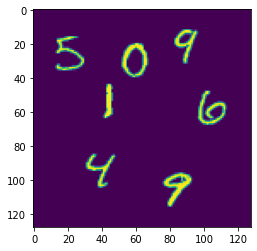

In [40]:
plt.imshow(img)

Let's segment this image.

In [41]:
segmented_image = segmenter.predict(np.expand_dims(img,axis=0))[0]

This segmented image has $11$, one for each class. And it has spatial dimensions $16x16$: much smaller image than the input image!!!

In [42]:
segmented_image.shape

(16, 16, 11)

We can transform this image with $11$ channels into a single-channels image containing, for each pixel, the predicted class. For doing so, we simply take, for each pixel, the maximum label $i$ across the channels.   

In [44]:
segmented_image_singleChannel = np.argmax(segmented_image,axis=-1)
segmented_image_singleChannel.shape

(16, 16)

In [45]:
print(segmented_image_singleChannel)

[[10 10 10 10 10 10 10 10 10 10 10  5 10 10 10 10]
 [10 10 10 10 10 10 10  5 10 10  4  7 10 10 10 10]
 [10  6  5  5 10 10  0  7 10 10  4  7 10 10 10 10]
 [10  5  3  3 10 10  4  4  1 10 10 10 10 10 10 10]
 [10 10 10 10 10 10  6  3 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  7 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  7 10 10 10 10 10  1  6  7 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  1  6  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  1  4 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  7  1 10 10 10  1  2 10 10 10 10 10]
 [10 10 10 10  6 10 10 10 10  4  7  1 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  6  7 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


The background seems correctly classified. And also the positions of the digits seem correctly classified.

### Visualizing the colored image

We can also visualize this segmented image with colors. Colored image: for each class, we use a different color.

In [46]:
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

cmap = get_cmap(12)

def cmap1(n):
  return cmap(n)[0:3]

print(cmap1(3),cmap1(10))

(0.38920293465748, 1.0, 0.0) (1.0, 0.0, 0.6306823551141734)


In [48]:
vcmap = np.vectorize(cmap1)
segmented_image_colored = np.array(vcmap(segmented_image_singleChannel))
segmented_image_colored = np.transpose(segmented_image_colored,(1,2,0))
print(segmented_image_colored.shape)

(16, 16, 3)


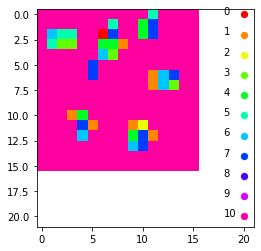

In [49]:
fig,ax = plt.subplots()
ax.imshow(segmented_image_colored)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

### Analysis of the results

The background is correctly classified. And also the positions of the digits. But the digits are not correctly classified.

**QUITE BAD RESULTS!**

## IMPROVING THE RESULTS

How can we improve the results? Many possible ways for doing so.

### Problem: spatial dimensions reduction

A first problem of convolutionalization that can be noticed is the fact that the output of the segmenter NN has much smaller spatial dimensions with respect to the input image. The segmented image has quite smaller spatial dimensions.

In our example, the input image has spatial dimensions $128x128$, while the segmented image has spatial dimensions $16x16$. This is a proble. We are lossing too much resolution. We would like to keep the same spatial dimensions.

Why is that? Because, in the segmenter NN, the Conv part decreases the spatial dimensions. Then, the last two Dense layers are applied independently and separately on each pixel: therefore, they leave the spatial dimensions unchanged.

This problem is addressed in the next notebook.

### Possilbe improvements

In the rest of this notebook, we discuss some possible improvements which can be carried out in our specific example.

## IMPROVEMENT 1

We know that the segmenter NN is the fully CNN version of the classifier NN, and it simply consists in sliding the classifier NN over the input image. 

Basically, the segmenter NN can be seen as a single convolution of a single kernel, which basically represents the classifier NN.

Since the classifier NN is convolved over the input images, it can happen that it is applied in a position in which the digit is not perfectly centered. The classifier NN can be applied in a portion of the image in which the digit is not perfectly centered. 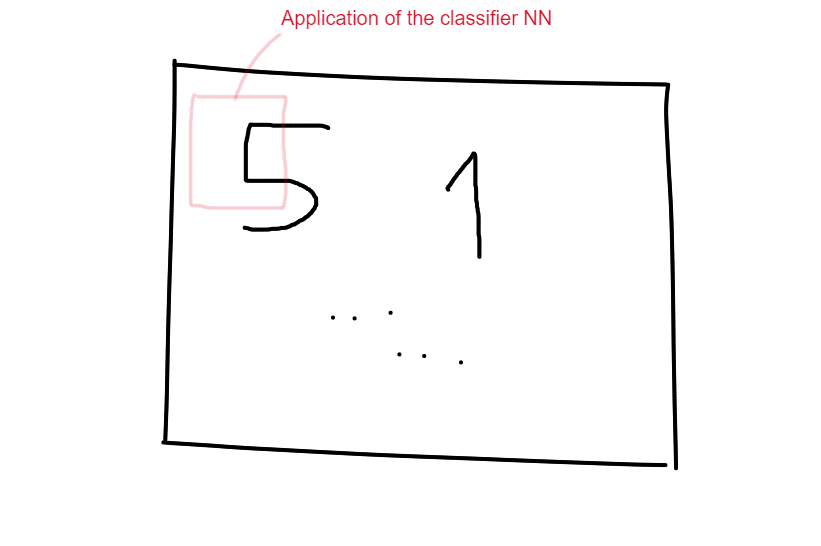

However, the classifier NN has been trained on the MNIST dataset, in which the digits are perfectly centered. So, the classifier NN has not been trained for handling this situation.

**Solution: we slightly modify the MNIST images s.t. the digits are not perfectly centered anymore.**

### Data augmentation

We implement this with data augmentation. We have already seen this before (for reducing overfitting).

During training, each training image is slightly changed, by randomly applying a shifting (we only apply translation, not rotation and zoom).

We could simply implement this by adding a layer into our classifier NN (layer rigth after the input layer). Instead, this time we implement data augmentation by means of a **generator**. We create a generator, after specifying our dataset and the operation we want to perform. Then, this generator yields to us the slightly changed images, on demand.

In [51]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# We define a generator for images, and we specify the kind of transformation we want
generator = ImageDataGenerator(width_shift_range=0.2, height_shift_range=0.2, horizontal_flip=False, fill_mode='nearest')

Let's test our generator.

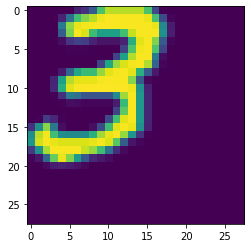

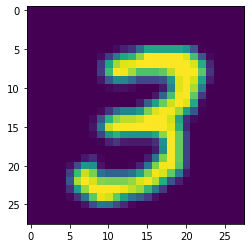

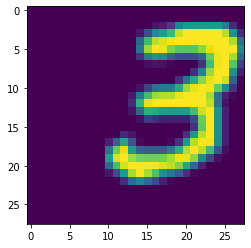

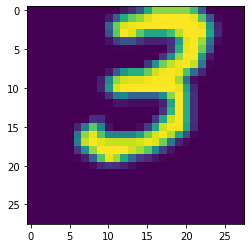

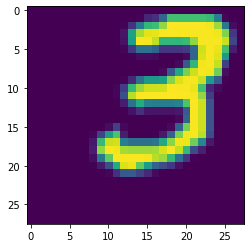

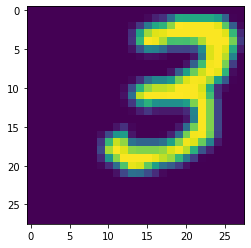

In [53]:
i = 0
for batch in generator.flow(x_train[7:8], batch_size=1):
    i += 1
    plt.imshow(batch[0,:,:,0])
    plt.show()
    if i > 5:
        break  # otherwise the generator would loop indefinitely

Good!

### Augmenting the training set

Now we apply the generator on our training set.

In [54]:
train_generator = generator.flow(x_train_bg, y_train_bg, batch_size=100)

### Training again the classifier NN

In [55]:
classifier.fit(train_generator, steps_per_epoch=600, epochs=5, validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 [==============================] - 16s 27ms/step - loss: 0.2224 - accuracy: 0.9312 - val_loss: 0.0789 - val_accuracy: 0.9753
Epoch 2/5
600/600 [==============================] - 16s 26ms/step - loss: 0.1130 - accuracy: 0.9646 - val_loss: 0.1053 - val_accuracy: 0.9648
Epoch 3/5
600/600 [==============================] - 16s 27ms/step - loss: 0.0943 - accuracy: 0.9706 - val_loss: 0.1139 - val_accuracy: 0.9621
Epoch 4/5
600/600 [==============================] - 16s 27ms/step - loss: 0.0847 - accuracy: 0.9732 - val_loss: 0.0784 - val_accuracy: 0.9749
Epoch 5/5
600/600 [==============================] - 16s 27ms/step - loss: 0.0767 - accuracy: 0.9757 - val_loss: 0.0810 - val_accuracy: 0.9713


In [56]:
classifier.save_weights("classifier1.hdf5")

### Loading the weigths into the segmenter NN

In [57]:
segmenter.load_weights("classifier1.hdf5")

### Applying the segmenter NN

In [58]:
segmented_image = segmenter.predict(np.expand_dims(img,axis=0))[0]

In [59]:
segmented_image_singleChannel = np.argmax(segmented_image,axis=-1)
print(segmented_image_singleChannel)

[[10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10  9  7 10 10 10 10]
 [10  2  5 10 10 10  1  7  1 10  4  1 10 10 10 10]
 [10 10  3 10 10 10  6  4  1 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10  5 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10  1 10 10 10 10 10  1  6  7 10 10]
 [10 10 10 10 10 10 10 10 10 10 10  4  6  3 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  6  4  1 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10  4  1 10 10 10  1  7 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  4  3 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10  3  1 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


In [60]:
segmented_image_colored = np.array(vcmap(segmented_image_singleChannel))
segmented_image_colored = np.transpose(segmented_image_colored,(1,2,0))
print(segmented_image_colored.shape)

(16, 16, 3)


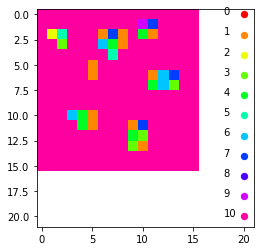

In [61]:
fig,ax = plt.subplots()
ax.imshow(segmented_image_colored)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

### Analysis of the results

Better results. But still not satisfactory.

## SECOND IMPROVEMENT

In the classifier NN, there is the GlobalMaxPooling operation. This operation is not present in the segmenter NN. We have removed it, because we don't want to flatten the spatial dimensions.

However, this Max Pooling operation is important for the classifier NN. Because it convolves information related to neighbour pixels into a single information. It captures and convolves information which is spread spatially. This kind of operation is important for our classifier NN.

In the segmenter NN we don't have this operation. So, while applying the classifier NN, this can impact the googness of the classification. 

Indeed, we can notice that in the results of the current segmenter NN, there is a weak spatial view: neighbour pixels related to the same digit are classified differently. 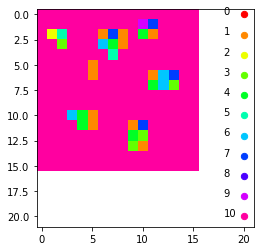

**Solution: we add into our segmenter NN a MaxPooling operation**. Important: we add a MaxPooling operation, not a MaxPooling operation. Because we don't want to flatten the spatial dimensions, we want to preserve them. We add this MaxPool layer in the same position there was the GlobalMaxPool layer.

### Another improvement

Moreover, we make another improvement: we make our classifier NN a little bit more complex and powerful. We add $3$ more Conv layers into our classifier NN: more sophisticated.

It is important to point out that we define these three new Conv layers with an unitarian stride: $S=1$. In this way, we are not further decreasing the spatial dimensions.

### Defining and training the classifier NN

In [62]:
# Input
xin = Input(shape=(28,28,1))

# Conv part
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
x = Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER

# FLattening
x = GlobalMaxPool2D()(x)

# Dense part
x = Dense(units=64, activation = 'swish')(x)
out = Dense(units=11, activation = 'softmax')(x) # 11 categories

# Model
classifier = Model(inputs=[xin],outputs=[out], name='classifier')

Compile

In [63]:
classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Train

In [64]:
classifier.fit(train_generator, steps_per_epoch=600, epochs=5, validation_data=(x_test_bg, y_test_bg))

Epoch 1/5
600/600 [==============================] - 23s 38ms/step - loss: 0.5407 - accuracy: 0.8190 - val_loss: 0.1891 - val_accuracy: 0.9386
Epoch 2/5
600/600 [==============================] - 22s 37ms/step - loss: 0.1382 - accuracy: 0.9567 - val_loss: 0.0958 - val_accuracy: 0.9704
Epoch 3/5
600/600 [==============================] - 23s 38ms/step - loss: 0.0955 - accuracy: 0.9701 - val_loss: 0.0873 - val_accuracy: 0.9720
Epoch 4/5
600/600 [==============================] - 22s 37ms/step - loss: 0.0763 - accuracy: 0.9766 - val_loss: 0.0642 - val_accuracy: 0.9810
Epoch 5/5
600/600 [==============================] - 23s 38ms/step - loss: 0.0654 - accuracy: 0.9799 - val_loss: 0.0599 - val_accuracy: 0.9799


In [65]:
classifier.save_weights("classifier2.hdf5")

### Defining the segmenter NN

Exactly equal to the classifier NN, except for the MaxPool layer instead of the GlobalMaxPooling layer. In this way, we don't flat the spatial dimensions.

It is important to point out that we define the MAxPool layer with unitarian stride $S=1$: in this way, we dont' further decrease the spatial dimensions.

In [67]:
from tensorflow.keras.layers import MaxPool2D

In [68]:
# Input
xin = Input(shape=(None,None,1))

# Conv layers (old Conv part)
x = Conv2D(filters=16, kernel_size=(3,3), strides=2, padding='same', activation='swish')(xin)
x = Conv2D(filters=16, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER
x = Conv2D(filters=32, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER
x = Conv2D(filters=64, kernel_size=(3,3), strides=2, padding='same', activation='swish')(x)
x = Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='swish')(x) # ADDITIONAL CONV LAYER

# Max Pooling
x = MaxPool2D((3,3),padding='same',strides=1)(x)

# Conv layers (old Dense part)
x = Dense(units=64, activation = 'swish')(x)
out = Dense(units=11, activation = 'softmax')(x) # 11 categories

# Model
segmenter = Model(inputs=[xin],outputs=[out], name='segmenter')

In [69]:
segmenter.load_weights("classifier2.hdf5")

### Applying the segmenter NN

In [70]:
segmented_image = segmenter.predict(np.expand_dims(img,axis=0))[0]

In [71]:
segmented_image_singleChannel = np.argmax(segmented_image,axis=-1)
print(segmented_image_singleChannel)

[[10 10 10 10 10 10 10 10 10  9  9  9  0 10 10 10]
 [ 5  5  5  5 10 10  0  0  0  9  9  9  6 10 10 10]
 [ 5  5  5  5  6  0  0  0  0  9  9  9  6 10 10 10]
 [ 5  5  5  5  6  0  0  0  0  7  4  1  1 10 10 10]
 [ 2  2  5  6  6  6  0  0  0 10 10 10 10 10 10 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  0 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  0 10]
 [10 10 10 10  1  1  1 10 10 10 10  6  6  6  0 10]
 [10 10 10 10 10 10 10 10 10 10 10  0  6  6  0 10]
 [10 10 10  6  6  6 10 10 10 10 10 10 10 10 10 10]
 [10 10 10  4  4  4  6 10 10  0 10 10 10 10 10 10]
 [10 10 10  4  4  4  1 10  9  9  8  8  6 10 10 10]
 [10 10 10  4  4  1  1 10  9  9  9  8  1 10 10 10]
 [10 10 10 10 10 10 10 10  9  7  9  8  5 10 10 10]
 [10 10 10 10 10 10 10 10 10  7 10 10 10 10 10 10]
 [10 10 10 10 10 10 10 10 10 10 10 10 10 10 10 10]]


In [72]:
segmented_image_colored = np.array(vcmap(segmented_image_singleChannel))
segmented_image_colored = np.transpose(segmented_image_colored,(1,2,0))
print(segmented_image_colored.shape)

(16, 16, 3)


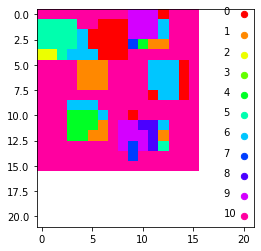

In [73]:
fig,ax = plt.subplots()
ax.imshow(segmented_image_colored)
for i in range(11):
  ax.text(18,2*i,str(i))
  ax.scatter(20,2*i,s=40,color=cmap1(i))
plt.show()

### Analysis of the results

Better results!!!

## IMPROVEMENT 3  
## TODO

If we analyze the current results, we can see that there are problems in the borders of the digits. 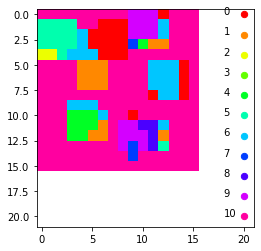

One possible reason of that may be that the training background images were not too good: they were almost perfect black images. So, the classifier classifies as background images only perfect black images.

But the classifier NN is now convolved across the input images. When it is applied in the border of an image, it should classify that as background, but instead it is confuesed by the fact that there is a little portion of something. 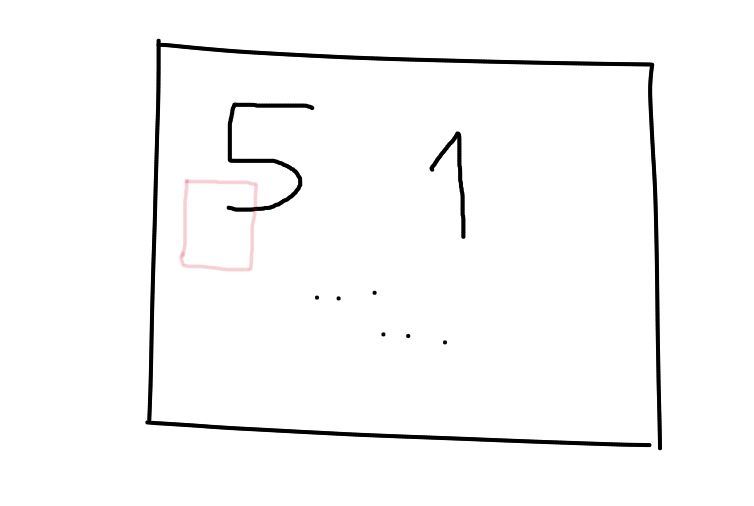

Solution: we modify our background training images, such that now they are not perfect black images, but they can contain a little portion of digits.